#### Gradient descent:
<br>

$f(x) \longrightarrow  \displaystyle \min_{x} $

$x^{t+1} = x^t-\alpha{f'(x^t)}$

$f(x^{t+1}) = f(x^t-\alpha{f'(x^t)})$

Например:

$f(\textbf{X}) = 10\cdot\sum\limits_{i, j}x_{ij}^2$

$f'(\textbf{X})_{\textbf{X}} = ? $

$f'(\textbf{X})_{x_{kl}} = \Big( 10\cdot\sum\limits_{i, j}x_{ij}^2\Big)_{x_{kl}}' = 10 \cdot\Big(\sum\limits_{i, j}x_{ij}^2\Big)_{x_{kl}}' $

$ \quad = 10 \cdot\sum\limits_{i, j}\Big(x_{ij}^2\Big)_{x_{kl}}' $

$ \quad = 10 \cdot\sum\limits_{i, j}2 x_{ij} \big(x_{ij}\big)_{x_{kl}}' $


$ \quad = 10 \cdot 2 x_{kl} \cdot 1 = 20 x_{kl} $

$f(\textbf{X}) = 10\cdot\sum\limits_{i, j}x_{ij}^2$

$f'(\textbf{X})_{\textbf{X}} = 20 \textbf{X} $

Тут $f(.)$ - функция, которая формализует весь граф нейронной сети и последующую loss-функцию

$X$ - тензор весов нейронной сети

# Реализация градиентного спуска в торче

- метод `backward` тензора-скаляра расчитывает производные всех операций с этим тензором, которые привели к его образованию, а результаты пишутся в атрибут `grad` тех аргументов-тензоров, из которых он был образован
- функция, по которой осуществляется градиентный спуск должна возвращать скаляр, иначе автоград не работает, т.е. это д.б. в конце `sum`, `mean` или какая другая агрегация/свертка
- а тензор д.б. вещественным

- атрибут `requires_grad=True`
  - cообщает о том, что данный тензор является переменной, по которой нужно будет считать градиенты
  - превращает тензор-константу в тензор-переменную (раньше надо было отдельно объявлять не как `Tensor`, а как `Variable`, но сейчас это где-то в наследовании классов автоматически добавляется такой миксин)

In [60]:
import torch

x = torch.tensor(
    [[1.,  2.,  3.,  4.],
     [5.,  6.,  7.,  8.],
     [9., 10., 11., 12.]], requires_grad=True)

#######
device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
x = x.to(device)
#######
function = 10 * (x ** 2).sum()

x.retain_grad() # иначе градиент пропадает, но только если на cuda, cpu ОК
function.backward() # 

print(x.grad, '<- gradient')  # изменение x[0,0] на 1 приведет к изменению function на 20
function

tensor([[ 20.,  40.,  60.,  80.],
        [100., 120., 140., 160.],
        [180., 200., 220., 240.]], device='cuda:0') <- gradient


tensor(6500., device='cuda:0', grad_fn=<MulBackward0>)

Как наша функция понимает, как вычислить по себе производную? 

Дело в том, что функция понимает, в каком порядке мы делали операции и знает аналитические формулы: как по этим операциям производить вычисление производной. 

Мы можем увидеть порядок вычисления, точнее порядок тех операций, которые мы производили, и даже вывести его на экран. Если мы возьмём у функции атрибут `grad_fn`, это будет последняя функция, которая привела к конечному результату.

In [61]:
print(function.grad_fn)
print(function.grad_fn.next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])

In [62]:
x = torch.tensor(
    [[1.,  2.,  3.,  4.],
     [5.,  6.,  7.,  8.],
     [9., 10., 11., 12.]], requires_grad=True)

In [63]:
function = 10 * (x ** 2).sum()
function.backward()

In [64]:
x, function

(tensor([[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]], requires_grad=True),
 tensor(6500., grad_fn=<MulBackward0>))

In [65]:
x.grad

tensor([[ 20.,  40.,  60.,  80.],
        [100., 120., 140., 160.],
        [180., 200., 220., 240.]])

Если вы хотите обновить тензор, у которого можно вычислить градиент, то не очень понятно, как это использовать в последующих вычислениях. То есть - как должна повести себя функция от этого обновленного тензора, должна ли она включить это вычисление своего градиента, или это некоторая пред-обработка тензора "x". Соответственно, PyTorch не разрешает такую операцию.
    
    x -= 0.001 * x.grad
    RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

- для этого есть атрибут `data`, это будет тот самый тензор, только с "requires_grad = False". И это никак не повлияет на вычисления последующих функций (операции с ним не попадут в дерево вычислений)

In [67]:
x.data -= 0.001 * x.grad
x.data, x.grad, x

(tensor([[ 0.9600,  1.9200,  2.8800,  3.8400],
         [ 4.8000,  5.7600,  6.7200,  7.6800],
         [ 8.6400,  9.6000, 10.5600, 11.5200]]),
 tensor([[ 20.,  40.,  60.,  80.],
         [100., 120., 140., 160.],
         [180., 200., 220., 240.]]),
 tensor([[ 0.9600,  1.9200,  2.8800,  3.8400],
         [ 4.8000,  5.7600,  6.7200,  7.6800],
         [ 8.6400,  9.6000, 10.5600, 11.5200]], requires_grad=True))

Второй тонкий момент -- то, что если мы будем производить эти операции многократно (у нас градиентный спуск - это итеративная операция), в PyTorch для удобства градиенты не обновляются после градиентных шагов - они всё время накапливаются в атрибуте `grad`

Поэтому, если нужно по смыслу, то нужно обнулять вручную.

- в торче названия методов с _ на конце означают, что метод изменяет объект на месте

In [8]:
x.grad.zero_()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

# Функция градиентного шага

- вспомогательная рисовалка траектории спуска

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-10.0, 10.0], 
                  y_lims=[-10.0, 10.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

- функция градиентного шага

In [69]:
import torch

x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

def function_parabola(variable):
    return 10 * (variable ** 2).sum()

def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= 0.001 * variable.grad
    variable.grad.zero_()

for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

- то же, с встроенным оптимайзером (как видно, не особо много он и делает, прост обертка для градиентного шага и переменной)
- причем выглядит теперь это более коряво, потому что оптимайзер должен заранее обернуть переменную, а не в функции шага, куда она также предается как `variable`

In [73]:
import torch

x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

optimizer = torch.optim.SGD([x], lr=0.001)

def function_parabola(variable):
    return 10 * (variable ** 2).sum()

def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    optimizer.step()
    optimizer.zero_grad()
    
for i in range(500):
    var_history.append(x.data.numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

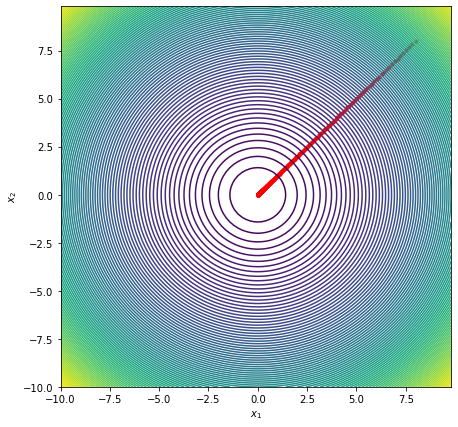

In [74]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

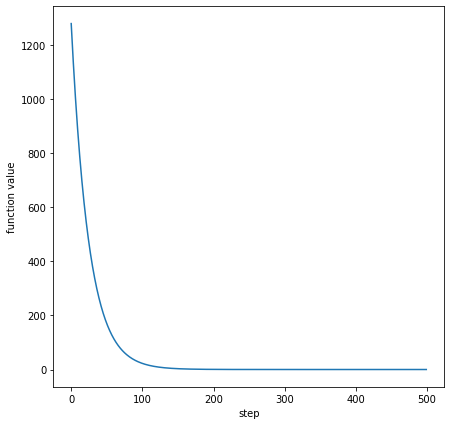

In [13]:
plt.figure(figsize=(7,7))
plt.plot(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

В логарифмической шкале видно, что уменьшение функции потерь идет по экспоненте ($e^{-x}$)

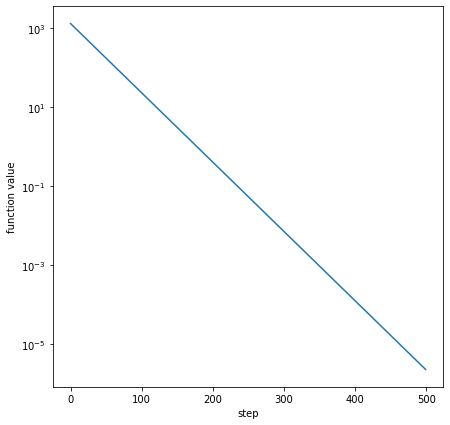

In [14]:
plt.figure(figsize=(7,7))
plt.semilogy(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

Поверхность посложение, видно движение перпендикулярно линиям уровня

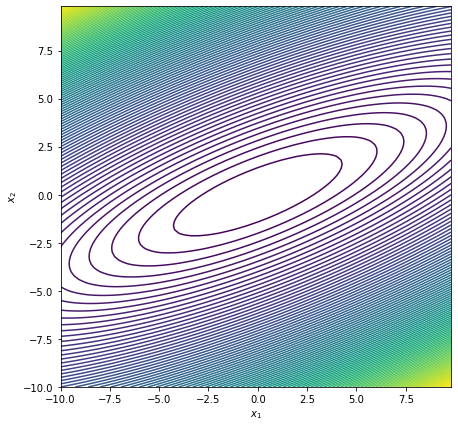

In [75]:
def function_skewed(variable):
    gramma = torch.tensor([[1., -1.], [1., 1.]]) @ torch.tensor([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.unsqueeze(0) @ (gramma @ variable.unsqueeze(1))).sum()
    return res

def function_skewed_np(variable):
    gramma = np.array([[1, -1], [1, 1]]) @ np.array([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.transpose(1, 0) @ (gramma @ variable)).sum()
    return res

show_contours(function_skewed_np)

In [76]:
x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

optimizer = torch.optim.SGD([x], lr=0.001)

for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_skewed(x).data.cpu().numpy().copy())
    make_gradient_step(function_skewed, x)

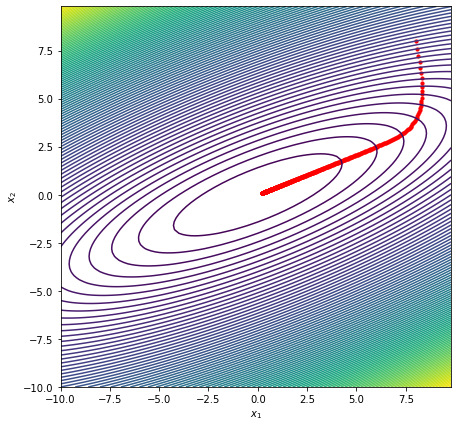

In [77]:
show_contours(function_skewed_np)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

Красивое...